Generate plot of SFNO-generated vs E3SMv2 distribution of precipitation.

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.zonal_spectrum import compute_zonal_time_mean_spectrum, plot_zonal_time_mean_spectra

_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

In [2]:
RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"

config = load_config("preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [3]:
OUTDIR = "figs/2024-05-01-precip-distr"
os.makedirs(OUTDIR, exist_ok=True)

In [4]:
PRECIP = "surface_precipitation_rate"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

PRECIP_CONVERSION = partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 -89.24 ... 8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    OCNFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    top_of_atmos_upward_shortwave_flux             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path_due_to_advection  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_1                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_0                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FLDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ICEFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
da = PRECIP_CONVERSION(ds[PRECIP])

with ProgressBar():
    da = da.resample(time="1D").mean("time").compute()

hist_range = da.min().compute().item(), da.max().compute().item()

[########################################] | 100% Completed | 41.6s


No latitude weighting:

In [7]:
%%time

precip_hist_ds = compute_histograms(da, n_bins=300, hist_range=hist_range, lat_weighted=False)
precip_hist_ds

CPU times: user 47.1 s, sys: 1.26 ms, total: 47.1 s
Wall time: 47.1 s


<xarray.Dataset>
Dimensions:    (source: 2, sample: 1, time: 3649, bin_id: 300, bin_edges: 301)
Coordinates:
  * source     (source) object 'target' 'prediction'
  * sample     (sample) int64 0
  * time       (time) object 0054-01-02 00:00:00 ... 0063-12-31 00:00:00
  * bin_id     (bin_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * bin_edges  (bin_edges) float64 -22.02 -19.33 -16.64 ... 780.2 782.9 785.6
Data variables:
    hist       (source, sample, time, bin_id) float64 0.0 0.0 0.0 ... 0.0 0.0

In [8]:
%%time

# (mean, std)
spectrum, _ = compute_zonal_time_mean_spectrum(da.isel(sample=0))

CPU times: user 8.41 s, sys: 4.98 s, total: 13.4 s
Wall time: 13.5 s


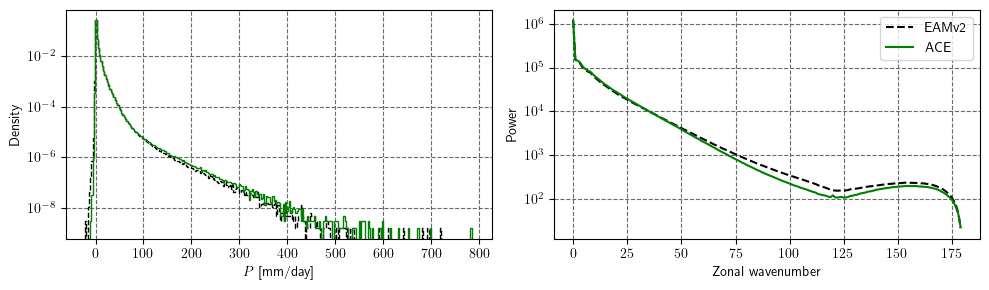

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

_ = plot_time_mean_histogram(
    precip_hist_ds,
    labels={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[0],
    log=True, 
    density=True, 
    histtype="step",
)

axs[0].set_xlabel(r"$P$ [mm/day]")
axs[0].set_ylabel("Density")

_ = plot_zonal_time_mean_spectra(
    spectrum,
    wavenumber_slice=slice(0, 179),
    source_to_label={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[1],
)
axs[1].set_ylabel("Power")

plt.minorticks_off()

for ax in axs:
    ax.grid(linestyle="--", color="dimgray")

plt.tight_layout()
    
fig.show()

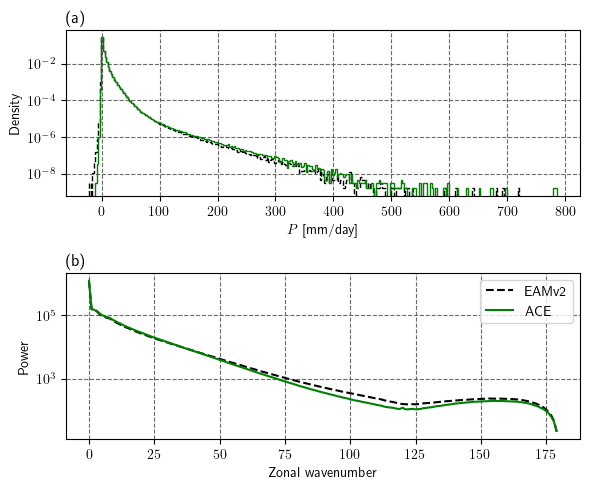

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

_ = plot_time_mean_histogram(
    precip_hist_ds,
    labels={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[0],
    log=True, 
    density=True, 
    histtype="step",
)

axs[0].set_xlabel(r"$P$ [mm/day]")
axs[0].set_ylabel(r"Density")
axs[0].set_title("(a)", loc="left")

_ = plot_zonal_time_mean_spectra(
    spectrum,
    wavenumber_slice=slice(0, 179),
    source_to_label={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[1],
)
axs[1].set_ylabel(r"Power")
axs[1].set_title("(b)", loc="left")

plt.minorticks_off()

for ax in axs:
    ax.grid(linestyle="--", color="dimgray")

plt.tight_layout()
    
fig.show()

In [11]:
fig.savefig(os.path.join(OUTDIR, "precip_distr.pdf"), bbox_inches="tight")

In [12]:
%%time

lat_weights = np.cos(np.deg2rad(da["lat"]))

spectrum_weighted, _ = compute_zonal_time_mean_spectrum(da.isel(sample=0), lat_weights=lat_weights)

CPU times: user 8.12 s, sys: 5.69 s, total: 13.8 s
Wall time: 15.2 s


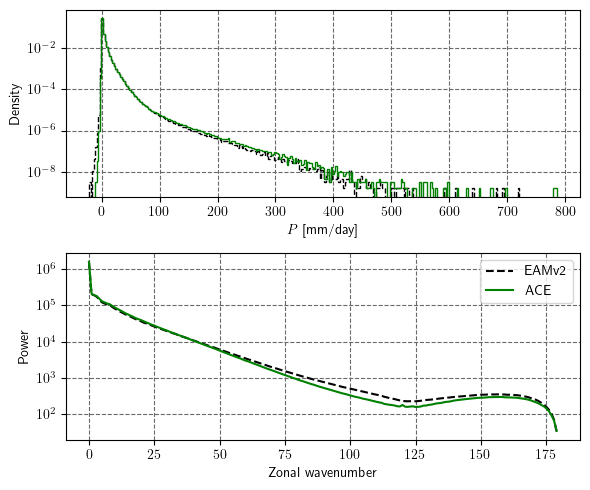

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

_ = plot_time_mean_histogram(
    precip_hist_ds,
    labels={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[0],
    log=True, 
    density=True, 
    histtype="step",
)

axs[0].set_xlabel(r"$P$ [mm/day]")
axs[0].set_ylabel(r"Density")

_ = plot_zonal_time_mean_spectra(
    spectrum_weighted,
    wavenumber_slice=slice(0, 179),
    source_to_label={
        "target": "EAMv2",
        "prediction": "ACE"
    },
    ax=axs[1],
)
axs[1].set_ylabel(r"Power")

plt.minorticks_off()

for ax in axs:
    ax.grid(linestyle="--", color="dimgray")

plt.tight_layout()
    
fig.show()